In [6]:
%matplotlib inline
from importlib import reload
import json
import sys
sys.path.append("..")
from pathlib import Path
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2
import umap

import pythd

In [2]:
DATA_DIR = Path("..") / Path("data") / "socal"
CHIP_SHAPE = (8, 8)
CHIP_STRIDE = (8, 8)

In [57]:
reload(pythd)
reload(pythd.image)

DAMAGE_LEVELS = {
    "un-classified": 1,
    "no-damage": 2,
    "minor-damage": 3,
    "major-damage": 4,
    "destroyed": 5
}

def process_image(pre_img, post_img, chip_size, chip_stride, lab_mean, lab_std):
    """
    Process and chip a single image
    """
    # Color transfer
    pre_img = cv2.cvtColor(pythd.image.normalize_image(pre_img), cv2.COLOR_RGB2Lab)
    post_img = cv2.cvtColor(pythd.image.normalize_image(post_img), cv2.COLOR_RGB2Lab)
    for i in range(pre_img.shape[2]):
        pre_img[:,:,i] = (pre_img[:,:,i] - pre_img[:,:,i].mean()) * (lab_std[i] / pre_img[:,:,i].std()) + lab_mean[i]
        post_img[:,:,i] = (post_img[:,:,i] - post_img[:,:,i].mean()) * (lab_std[i] / post_img[:,:,i].std()) + lab_mean[i]
        
    pre_img = pythd.image.normalize_image(cv2.cvtColor(pre_img, cv2.COLOR_Lab2RGB))
    pre_img = (pre_img * 255.0).astype(np.uint8)
    post_img = pythd.image.normalize_image(cv2.cvtColor(post_img, cv2.COLOR_Lab2RGB))
    post_img = (post_img * 255.0).astype(np.uint8)
    
    dfs = []
    for k, img in {"pre": pre_img, "post": post_img}.items():
        # RGB
        df = pythd.image.ChippedImage.FromRGB(img, chip_size, chip_stride).df
        cols = [col for col in df.columns if "pixel" in col]
        df.loc[:, cols] = (df.loc[:, cols] - df.loc[:, cols].mean(axis=0)) / df.loc[:, cols].std(axis=0)
        df.columns = [k + "_" + col for col in df.columns]
        dfs.append(df)

        # Edges
        edges = cv2.Canny(img, threshold1=100, threshold2=200, apertureSize=3, L2gradient=True)
        edges = pythd.image.normalize_image(edges)
        edges_df = pythd.image.ChippedImage.FromGrayscale(edges, chip_size, chip_stride).df
        cols = [col for col in edges_df.columns if "pixel" in col]
        edges_df = edges_df.loc[:, cols]
        edges_df.columns = [k + "_edge " + col for col in edges_df.columns]
        dfs.append(edges_df)
        
        # Corners
        corners = cv2.cornerHarris(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 4, 3, 0.04)
        corners = pythd.image.normalize_image(corners)
        corners_df = pythd.image.ChippedImage.FromGrayscale(corners, chip_size, chip_stride).df
        cols = [col for col in corners_df.columns if "pixel" in col]
        corners_df = corners_df.loc[:, cols]
        corners_df.columns = [k + "_corner " + col for col in corners_df.columns]
        dfs.append(corners_df)
    
    df = pd.concat(dfs, axis=1)
    df.drop(["post_x", "post_y"], axis=1, inplace=True)
    df.rename({"pre_x": "x", "pre_y": "y"}, axis=1, inplace=True)
    return df

def build_chipped_df(images, chip_size=(16,16), chip_stride=(16,16)):
    """
    Build a chipped dataframe from a list of image paths
    """
    dfs = []
    cw, ch = chip_size
    sx, sy = chip_stride
    
    tmp_img = io.imread(images[0])
    tmp_img = cv2.cvtColor(pythd.image.normalize_image(tmp_img), cv2.COLOR_RGB2Lab)
    lab_mean = tmp_img.mean(axis=(0,1))
    lab_std = tmp_img.std(axis=(0,1))
    
    for pre_path in tqdm(list(images)):
        #pre disaster image
        pre_img = io.imread(str(pre_path))
        h, w = pre_img.shape[:2]
        post_path = DATA_DIR / pre_path.name.replace("pre", "post")
        post_img = io.imread(str(post_path))
        df = process_image(pre_img, post_img, chip_size, chip_stride, lab_mean, lab_std)
        df["image"] = pre_path.name
        df.astype({"x": "int32", "y": "int32"}, copy=False)
        df["building"] = 0
        df["damage"] = 1
        
        # labels
        label_path = DATA_DIR / post_path.name.replace("png", "json")
        if label_path.exists():
            label_mask = np.zeros((h, w), dtype=np.uint8)
            with open(label_path, "r") as f:
                labels = json.load(f)
                labels = labels["features"]["xy"]
                for o in [obj for obj in labels if (obj["properties"]["feature_type"] == "building")]:
                    coords = o["wkt"][10:-2].split(', ')
                    bbox= np.array([list(map(lambda x: int(float(x)), coord.split(' '))) for coord in coords])
                    damage = DAMAGE_LEVELS[o["properties"]["subtype"]]
                    cv2.fillPoly(label_mask, [bbox], color=damage)
            
            for row in df.index:
                x = int(df.loc[row, "x"])
                y = int(df.loc[row, "y"])
                chip = label_mask[y:(y+ch), x:(x+cw)]
                df.loc[row, "building"] = int((chip > 0).any())
                df.loc[row, "damage"] = chip.max()
        dfs.append(df)
    
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    return dfs

df = build_chipped_df(list(DATA_DIR.glob("*pre_disaster.png")), chip_size=CHIP_SHAPE, chip_stride=CHIP_STRIDE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.53s/it]


In [58]:
features = [c for c in df.columns if "pixel" in c]
data = df.loc[:, features].values
print(df.shape)
print(df["image"].unique())
df.head()

(49152, 645)
['socal-fire_00000082_pre_disaster.png'
 'socal-fire_00000308_pre_disaster.png'
 'socal-fire_00000484_pre_disaster.png']


x    y  pre_pixel 1  pre_pixel 2  pre_pixel 3  pre_pixel 4  pre_pixel 5  \
0   0.0  0.0    -0.417255    -0.212874    -0.326533    -0.318518     0.077244   
1   8.0  0.0    -0.368277    -0.010979    -0.230754     0.000416     0.337548   
2  16.0  0.0    -0.000943    -0.010979    -0.007272    -0.048651    -0.096292   
3  24.0  0.0    -0.858056    -1.106978    -0.933127    -0.514786    -0.732590   
4  32.0  0.0     0.390880     0.392809     0.439692     0.515618     0.453238   

   pre_pixel 6  pre_pixel 7  pre_pixel 8  ...  post_corner pixel 58  \
0    -0.165761    -0.051291     0.595553  ...              0.100676   
1     0.154793    -0.051291     0.189912  ...              0.100675   
2    -0.037539    -0.542349    -0.650344  ...              0.100703   
3    -0.518370    -0.738773    -0.940087  ...              0.100968   
4     0.539457     0.562532     0.479656  ...              0.100825   

   post_corner pixel 59  post_corner pixel 60  post_corner pixel 61  \
0              0.100677              0.100677              0.100676   
1              0.100675              0.100675              0.100676   
2              0.100694              0.100699              0.100817   
3              0.100909              0.100856              0.100788   
4              0.100767              0.100747              0.100698   

   post_corner pixel 62  post_corner pixel 63  post_corner pixel 64  \
0              0.100676              0.100676              0.100676   
1              0.100682              0.100702              0.100710   
2              0.101045              0.101219              0.101425   
3              0.100770              0.100847              0.100927   
4              0.100687              0.100683              0.100679   

                                  image  building  damage  
0  socal-fire_00000082_pre_disaster.png         0       0  
1  socal-fire_00000082_pre_disaster.png         0       0  
2  socal-fire_00000082_pre_disaster.png         0       0  
3  socal-fire_00000082_pre_disaster.png         0       0  
4  socal-fire_00000082_pre_disaster.png         0       0  

[5 rows x 645 columns]

In [59]:
filt = pythd.filter.ScikitLearnFilter(umap.UMAP, n_neighbors=10, n_components=2, metric='cosine')
filt.fit(data)

In [60]:
f_x = filt(data)

In [64]:
reload(pythd)
reload(pythd.thd)
reload(pythd.complex)
reload(pythd.cover)
reload(pythd.mapper)
reload(pythd.clustering)

clustering = pythd.clustering.HierarchicalClustering(metric='cosine', method='average')
cover = pythd.cover.IntervalCover.EvenlySpacedFromValues(f_x, 30, 0.25)
thd = pythd.thd.THD(data, filt, cover, group_threshold=200, contract_amount=0.2)
thd.run(verbose=True)
root = thd.get_results()

1 jobs remaining
Group 0.0.0 finished (49152 rids)
4 jobs remaining
Group 1.0.0 finished (255 rids)
3 jobs remaining
Group 1.1.0 finished (255 rids)
2 jobs remaining
Group 1.2.0 finished (255 rids)
1 jobs remaining
Group 1.3.0 finished (47751 rids)
1 jobs remaining
Group 2.0.3 finished (47476 rids)
1 jobs remaining
Group 3.0.0 finished (46587 rids)
1 jobs remaining
Group 4.0.0 finished (206 rids)


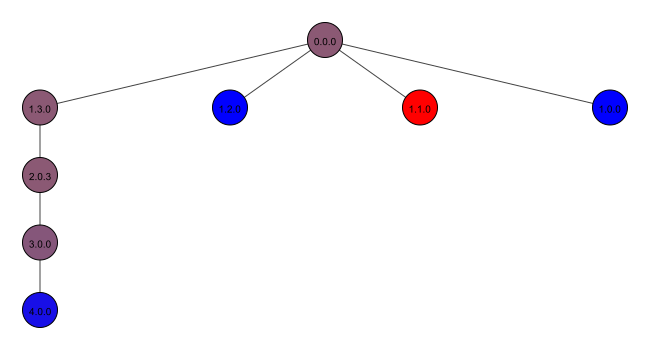

In [65]:
import igraph
root.color_by_value(df["building"].values, normalize=True)
#root.color_density(normalize=True)
g = root.as_igraph_graph()
vs = {
    "margin": 40,
    "bbox": (650, 350),
    "vertex_label": g.vs["name"],
    "vertex_label_size": 10,
    "vertex_size": 35,
    "vertex_label_dist": 0,
    "vertex_label_angle": 0,
    "layout": g.layout_reingold_tilford(root=[0])
}
igraph.plot(g, **vs)

In [52]:
def show_group_image(group, i=0, which='pre'):
    images = df["image"].iloc[list(group.rids)].unique()
    gdata = df.iloc[list(group.rids), :]
    img_name = images[i]
    gdata = gdata[gdata["image"] == img_name]

    img_path = DATA_DIR / img_name
    if which == 'pre':
        img_path = DATA_DIR / img_name.replace('post', 'pre')
    else:
        img_path = DATA_DIR / img_name.replace('pre', 'post')
    img = io.imread(str(img_path))
    mask = np.zeros(img.shape[:2], dtype=np.float32)
    cw, ch = CHIP_SHAPE

    for x, y in zip(gdata["x"].values, gdata["y"].values):
        x, y = (int(x), int(y))
        mask[y:(y+ch), x:(x+cw)] = 1

    overlay = pythd.image.overlay_mask(img, mask, image_alpha=0.6)

    pythd.image.plot_images((overlay,))

group = root.get_group_by_name("8.4.1")
images = df["image"].iloc[list(group.rids)].unique()
print(images)

['socal-fire_00000484_pre_disaster.png'
 'socal-fire_00000082_pre_disaster.png'
 'socal-fire_00000308_pre_disaster.png']


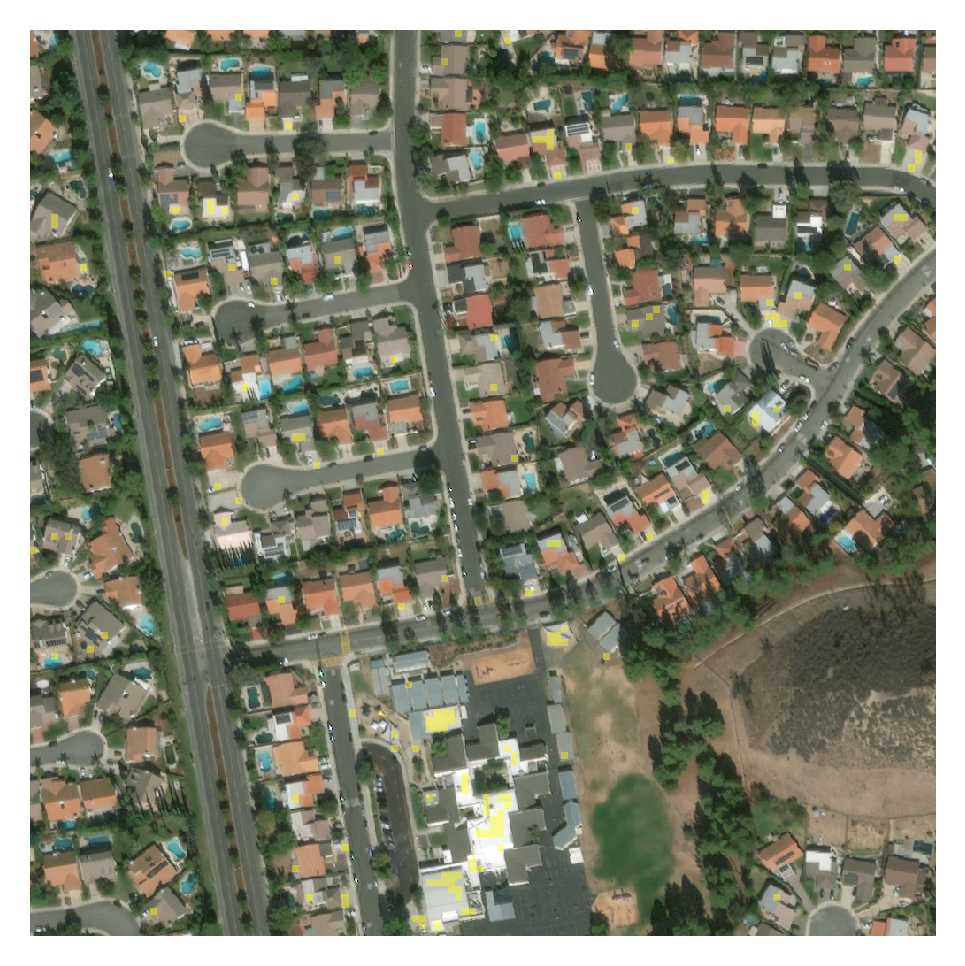

In [53]:
show_group_image(group, 0)

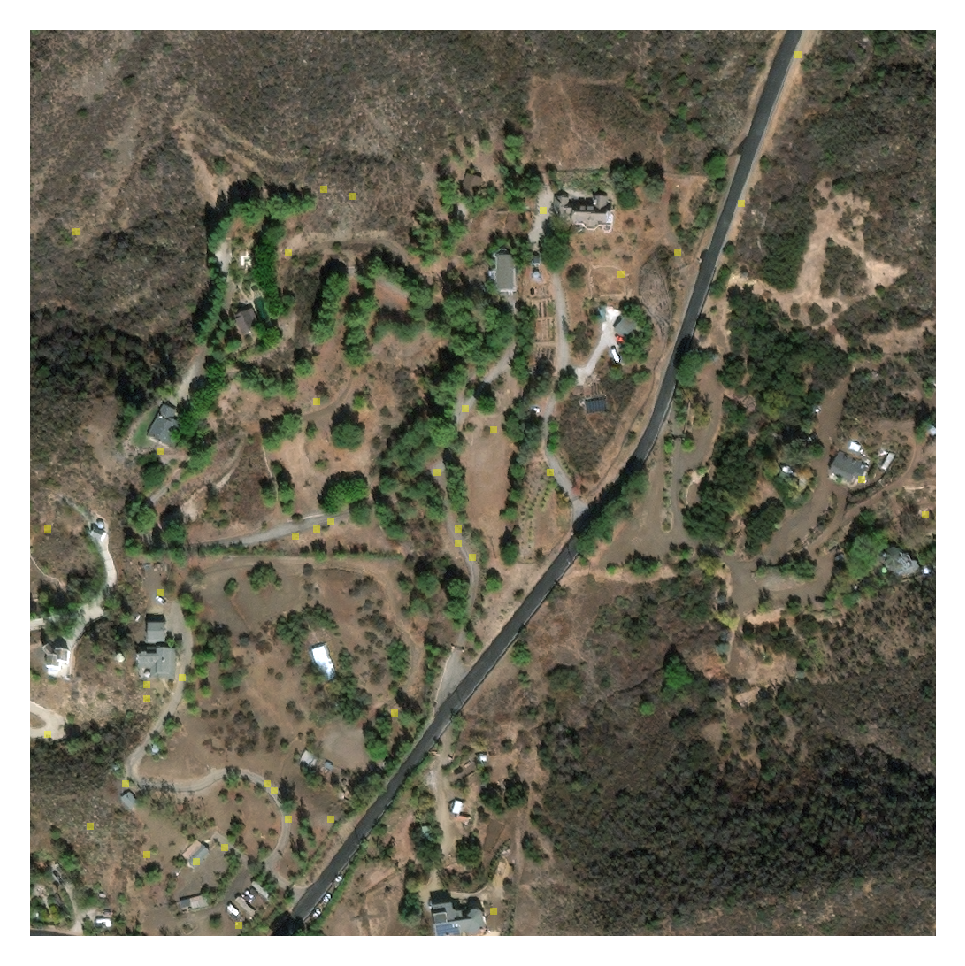

In [54]:
show_group_image(group, 1)

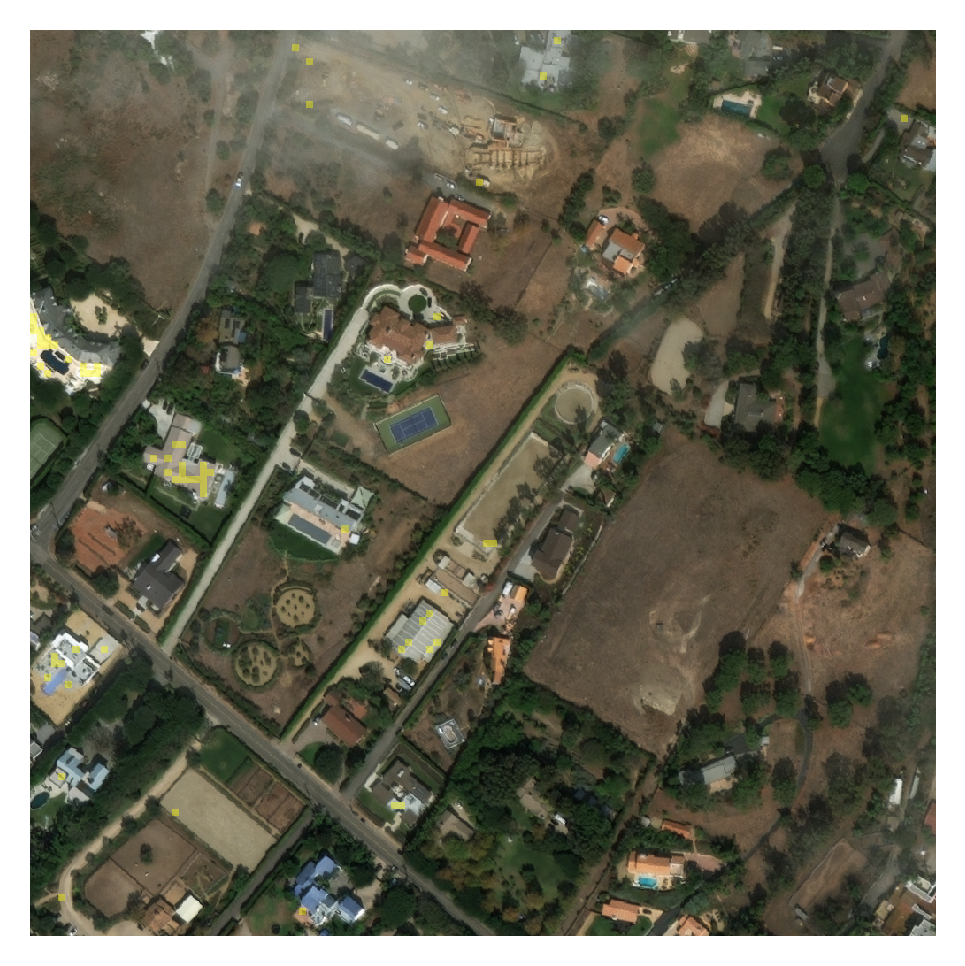

In [55]:
show_group_image(group, 2)

In [ ]:
show_group_image(group, 3)

In [ ]:
show_group_image(group, 4)

In [ ]:
show_group_image(group, 5)

In [ ]:
show_group_image(group, 6)

In [ ]:
root.color_by_value(df["damage"].values, normalize=True)
g = root.as_igraph_graph()
vs = {
    "margin": 40,
    "bbox": (650, 350),
    "vertex_label": g.vs["name"],
    "vertex_label_size": 10,
    "vertex_size": 35,
    "vertex_label_dist": 0,
    "vertex_label_angle": 0,
    "layout": g.layout_reingold_tilford(root=[0])
}
igraph.plot(g, **vs)

In [ ]:
group = root.get_group_by_name("2.19.0")
images = df["image"].iloc[list(group.rids)].unique()
print(images)

In [ ]:
show_group_image(group, 0, which='post')

In [ ]:
show_group_image(group, 1, which='post')

In [ ]:
show_group_image(group, 2, which='post')

In [ ]:
show_group_image(group, 3, which='post')

In [ ]:
show_group_image(group, 4, which='post')

In [ ]:
show_group_image(group, 5, which='post')

In [ ]:
show_group_image(group, 6, which='post')